# Predicting MotoGP Winners

### Supervised Learning

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

#pd.options.mode.chained_assignment = None

Reading in the data

In [2]:
df_motogpsession = pd.read_csv('data/motogpsession.tsv', sep='\t', encoding='utf-8')
df_motogpqresult = pd.read_csv('data/motogpqresult.tsv', sep='\t', encoding='utf-8')
df_motogprresult = pd.read_csv('data/motogprresult.tsv', sep='\t', encoding='utf-8')
df_motogprider = pd.read_csv('data/motogprider.tsv', sep='\t', encoding='utf-8')

In [3]:
df_motogpsession = df_motogpsession.loc[:, ~df_motogpsession.columns.str.contains('^Unnamed')]
df_motogpqresult = df_motogpqresult.loc[:, ~df_motogpqresult.columns.str.contains('^Unnamed')]
df_motogprresult = df_motogprresult.loc[:, ~df_motogprresult.columns.str.contains('^Unnamed')]
df_motogprider = df_motogprider.loc[:, ~df_motogprider.columns.str.contains('^Unnamed')]

In [4]:
dict_motogpdata = {}

dict_motogpdata['session'] = df_motogpsession
dict_motogpdata['qresult'] = df_motogpqresult
dict_motogpdata['rresult'] = df_motogprresult
dict_motogpdata['rider'] = df_motogprider

We first need to generate our set of features and label

In [5]:
def generate_labelfeat(dict_motodata):
    """ """

    df_motosession = dict_motodata['session']
    df_motoqresult = dict_motodata['qresult']
    df_motorresult = dict_motodata['rresult']
    df_motorider = dict_motodata['rider']

    # Create dictonary for session id to session type
    dict_sessionidsession = df_motosession.set_index('sessionId')['sessionSession'].to_dict()

    # Create dictonary for session id to race session id
    dict_sessionidracsessionid = {}
    for index, row in df_motosession.iterrows():
        sessionid = row['sessionId']
        sessionseason = row['sessionSeason']
        sessioncountry = row['sessionCountry']

        df_temp1 = df_motosession[(df_motosession['sessionSeason'] == sessionseason) & \
                                  (df_motosession['sessionCountry'] == sessioncountry) & \
                                  (df_motosession['sessionSession'] == 'RAC2')]

        df_temp2 = df_motosession[(df_motosession['sessionSeason'] == sessionseason) & \
                                  (df_motosession['sessionCountry'] == sessioncountry) & \
                                  (df_motosession['sessionSession'] == 'RAC')]

        if len(df_temp1) > 0:
            dict_sessionidracsessionid[sessionid] = df_temp1['sessionId'].values[0]

        elif len(df_temp2) > 0:
            dict_sessionidracsessionid[sessionid] = df_temp2['sessionId'].values[0]

        else:
            # print(sessionid, sessionseason, sessioncountry)
            dict_sessionidracsessionid[sessionid] = np.nan

    # Copy qualifying result dataframe
    df_temp = df_motoqresult.copy()

    # Add session type to qresults
    df_temp['sessionId2'] = df_temp['sessionId']
    df_temp['sessionId2'] = df_temp['sessionId2'].replace(dict_sessionidsession)
    df_temp = df_temp.rename(columns={'sessionId2': 'sessionSession'})

    # Add race session id
    df_temp['sessionId3'] = df_temp['sessionId']
    df_temp['sessionId3'] = df_temp['sessionId3'].replace(dict_sessionidracsessionid)
    df_temp = df_temp.rename(columns={'sessionId3': 'racsessionId'})

    # Drop records which are missing race session id
    df_temp = df_temp.dropna(subset=['racsessionId'])

    # Crete new race session id + rider id index
    df_temp['racsessionriderId'] = df_temp['racsessionId'].map(str) + '_' + df_temp['riderId'].map(str)
    df_temp = df_temp.drop(['sessionId', 'riderId', 'racsessionId'], 1)

    # Pivot table on new index and to new fields as needed
    df_temp = df_temp.pivot(index='racsessionriderId', columns='sessionSession')
    df_temp.columns = [str(x) + str(y) for x, y in list(df_temp.columns)]
    df_temp = df_temp.reset_index()
    df_ids = df_temp.racsessionriderId.str.split('_').apply(pd.Series)
    df_ids.columns = ['racsessionId', 'riderId']
    df_temp = pd.concat([df_temp, df_ids], axis=1)

    # Drop race session id + rider id index
    df_temp = df_temp.drop('racsessionriderId', 1)
    df_temp = df_temp.rename(columns={'racsessionId': 'sessionId'})
    df_temp[['sessionId', 'riderId']] = df_temp[['sessionId', 'riderId']].astype(float)

    # Merge race result, rider and session data
    df_temp = pd.merge(df_temp, df_motorresult, on=['riderId', 'sessionId'], how='left')
    df_temp = pd.merge(df_temp, df_motorider, on='riderId', how='left')
    df_temp = pd.merge(df_temp, df_motosession, on='sessionId', how='left')

    df_index = df_temp[['sessionId', 'sessionSeason', 'sessionCountry', 'riderId', 'riderName']].copy()

    # Extract sessionId
    list_sessionId = df_temp['sessionId']

    # Drop unnecessary and non-feature fields
    df_temp = df_temp.drop(['riderId',
                            # 'riderName',
                            'riderNumber',
                            'rresultTotaltime',
                            'rresultAvgspeed',
                            'sessionId',
                            'sessionSeason',
                            'sessionClass',
                            'sessionCountry',
                            'sessionSession',
                            'sessionDate'], 1)

    # Insert sessionId back as first column in features dataframe
    df_temp.insert(0, 'sessionId', list_sessionId)

    # Convert race result field to 0/1
    df_temp['rresultPlace'][df_temp['rresultPlace'] > 1] = 0
    df_temp['rresultPlace'] = df_temp['rresultPlace'].fillna(0)

    # Extract label and features dataframe
    df_label = df_temp[['rresultPlace']]
    df_features = df_temp.drop('rresultPlace', 1)

    return df_label, df_features

In [6]:
df_motogplabel, df_motogpfeatures = generate_labelfeat(dict_motogpdata)

C:\Users\buswedg\Anaconda3\envs\Python37\lib\site-packages\ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
print(len(df_motogpfeatures.columns))

71


In [8]:
def convertdatetime(dt):
    """ """

    import re
    import numpy as np

    from datetime import datetime

    dt = str(dt)

    if dt == 'None':
        return np.NaN

    else:
        f = '\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}.\d{6}'
        r = re.compile(f)
        if r.match(dt) is None:
            dt = dt + '.000000'

        try:
            f = '%Y-%m-%d %H:%M:%S.%f'
            a = datetime.strptime(dt, f)
            b = datetime(1900, 1, 1)
        except:
            return np.NaN

        return (a - b).total_seconds()

    
def preprocess_features(df_in):
    """ """

    import pandas as pd

    list_ignorecolumns = ['sessionId']

    list_timecolumns = ['qresultBesttimeFP',
                        'qresultBesttimeFP1',
                        'qresultBesttimeFP2',
                        'qresultBesttimeFP3',
                        'qresultBesttimeFP4',
                        'qresultBesttimeQP',
                        'qresultBesttimeQP1',
                        'qresultBesttimeQP2',
                        'qresultBesttimeQ1',
                        'qresultBesttimeQ2',
                        'qresultBesttimeWUP',
                        'qresultBesttimeWUP2']

    df_out = pd.DataFrame(index=df_in.index)
    for col_name, col_values in df_in.iteritems():
        if col_name in list_ignorecolumns:
            col_values = col_values

        elif col_name in list_timecolumns:
            col_values = col_values.astype(str)
            col_values = col_values.apply(convertdatetime)

        elif col_values.dtype == object:
            col_values = col_values.replace(['yes', 'no'], [1, 0])
            col_values = pd.get_dummies(col_values, prefix=col_name)
        df_out = df_out.join(col_values)

        df_out = df_out.fillna(0)

    return df_out

In [9]:
df_motogpallfeatures = preprocess_features(df_motogpfeatures)

Generate kbest feature scores and plot

In [10]:
def generate_kbestscores(df_label, df_features, k):
    """ """

    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_classif

    list_features = df_features.columns

    kbsel = SelectKBest(k=k, score_func=f_classif).fit(df_features, df_label['rresultPlace'].values)

    # Create tables for the K-best features Anova F-value.
    df_kbfeat = pd.DataFrame([list_features, kbsel.scores_]).T
    df_kbfeat.columns = ['Feature', 'Anova F-value']
    df_kbfeat = df_kbfeat.sort_values(['Anova F-value'], ascending=False).reset_index(drop=True)

    return df_kbfeat

In [11]:
df_kbfeatscoresmotogp = generate_kbestscores(df_motogplabel, df_motogpallfeatures, 'all')

df_kbfeatscoresmotogp

,Feature,Anova F-value
0,qresultPlaceFP2,334.354
1,qresultPlaceWUP,328.166
2,qresultPlaceFP1,304.539
3,riderName_Casey STONER,266.57
4,riderName_Marc MARQUEZ,248.286
...,...,...
400,sessionTrackname_Sachsenring,4.53492e-05
401,sessionTrackname_Autodromo del Mugello,4.53492e-05
402,sessionTrackname_Losail International Circuit,4.31584e-05
403,riderTeam_Red Bull Yamaha WCM,1.13509e-05


In [35]:
def generate_kbestfeatplot(df_kbfeat):
    """ """

    plt.clf()

    fig = plt.figure(figsize=(16, 6))

    ax = sns.barplot(x='Feature',
                     y='Anova F-value',
                     data=df_kbfeat, color='c')

    ax.set_xticklabels(ax.get_xticklabels(),
                       rotation=45, ha='right')

    ax.set_title('MotoGP 2007-17 - Variable Importance')
    ax.set_ylabel('Anova F-value')

    return fig

<Figure size 432x288 with 0 Axes>

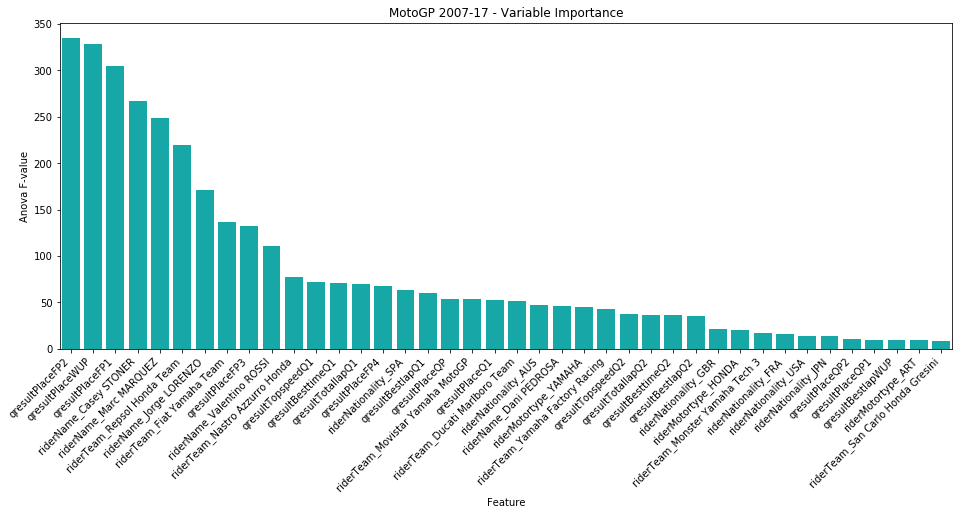

In [36]:
fig = generate_kbestfeatplot(df_kbfeatscoresmotogp[:40])

In [37]:
fig.savefig('images/motogpkbest.png', bbox_inches='tight', pad_inches=0.2)

Create the final feature dataframe

In [15]:
list_motogpkbestfeatures = ['sessionId',
                          'qresultPlaceFP',
                          'qresultPlaceFP1',
                          'qresultPlaceFP2',
                          'qresultPlaceFP3',
                          'qresultPlaceFP4',
                          'qresultPlaceQ1',
                          'qresultPlaceQ2',
                          'qresultPlaceQP',
                          'qresultPlaceQP1',
                          'qresultPlaceQP2',
                          'qresultPlaceWUP',
                          'qresultBestlapFP',
                          'qresultBestlapFP1',
                          'qresultBestlapFP2',
                          'qresultBestlapFP3',
                          'qresultBestlapFP4',
                          'qresultBestlapQ1',
                          'qresultBestlapQ2',
                          'qresultBestlapQP',
                          'qresultBestlapQP1',
                          'qresultBestlapQP2',
                          'qresultBestlapWUP',
                          'qresultTopspeedFP',
                          'qresultTopspeedFP1',
                          'qresultTopspeedFP2',
                          'qresultTopspeedFP3',
                          'qresultTopspeedFP4',
                          'qresultTopspeedQ1',
                          'qresultTopspeedQ2',
                          'qresultTopspeedQP',
                          'qresultTopspeedQP1',
                          'qresultTopspeedQP2',
                          'qresultTopspeedWUP',
                          'qresultTotallapFP',
                          'qresultTotallapFP1',
                          'qresultTotallapFP2',
                          'qresultTotallapFP3',
                          'qresultTotallapFP4',
                          'qresultTotallapQ1',
                          'qresultTotallapQ2',
                          'qresultTotallapQP',
                          'qresultTotallapQP1',
                          'qresultTotallapQP2',
                          'qresultTotallapWUP',
                          'qresultBesttimeFP',
                          'qresultBesttimeFP1',
                          'qresultBesttimeFP2',
                          'qresultBesttimeFP3',
                          'qresultBesttimeFP4',
                          'qresultBesttimeQ1',
                          'qresultBesttimeQ2',
                          'qresultBesttimeQP',
                          'qresultBesttimeQP1',
                          'qresultBesttimeQP2',
                          'qresultBesttimeWUP']

df_motogpkbestfeatures = df_motogpallfeatures[list_motogpkbestfeatures]

Create some helpers for our supervised learning routines

In [16]:
def shuffle_split_data(y_true_all, X_all, test_size):
    """  """

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_true_train, y_true_test = train_test_split(X_all, y_true_all, test_size=test_size)

    return X_train, y_true_train, X_test, y_true_test

In [17]:
def eval_clf(clf, X, y_true, metric):
    """  """

    y_pred = clf.predict_proba(X[:, 1:])
    y_pred = convert_pred(X[:, 0], y_pred[:, 1])

    score = performance_metric(y_true, y_pred, metric)

    return score

In [18]:
def convert_pred(sessionId, y_pred_orig):
    """ """

    import pandas as pd

    df_temp = pd.DataFrame({'sessionId': sessionId, 'y_pred_orig': y_pred_orig})

    df_temp['y_pred_adj'] = 0

    for s in df_temp['sessionId'].unique():
        max_prob = df_temp[df_temp['sessionId'] == s]['y_pred_orig'].max()
        if max_prob >= 0.5:
            df_temp.loc[(df_temp['sessionId'] == s) & (df_temp['y_pred_orig'] == max_prob), 'y_pred_adj'] = 1

    y_pred_adj = df_temp['y_pred_adj'].values

    return y_pred_adj

In [19]:
def performance_metric(y_true, y_pred, metric):
    """  """

    from sklearn.metrics import accuracy_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score

    if metric == 'accuracy':
        score = accuracy_score(y_true, y_pred)
    elif metric == 'f1':
        score = f1_score(y_true, y_pred)
    elif metric == 'recall':
        score = recall_score(y_true, y_pred)
    elif metric == 'precision':
        score = precision_score(y_true, y_pred)

    return score

Generate learning curve plots

In [20]:
def generate_learningcurves(y_true_all, X_all, metric):
    """ """

    np.random.seed(0)

    plt.clf()

    fig = plt.figure(figsize=(18, 10))

    training_sizes = np.round(np.linspace(0.1, 0.9, 5), 10)

    # DT -------------------------------

    from sklearn.tree import DecisionTreeClassifier

    df_temp = pd.DataFrame(columns=['s', 'score', 'set'])

    for s in training_sizes:
        for i in range(0, 5):
            X_train, y_true_train, X_test, y_true_test = shuffle_split_data(y_true_all, X_all, 1 - s)

            clf = DecisionTreeClassifier()
            clf = clf.fit(X_train[:, 1:], y_true_train)

            train_s = eval_clf(clf, X_train, y_true_train, metric)
            test_s = eval_clf(clf, X_test, y_true_test, metric)

            df_temp.loc[len(df_temp.index)] = [s, test_s, 'test']
            df_temp.loc[len(df_temp.index)] = [s, train_s, 'train']

    ax = fig.add_subplot(2, 3, 1)

    ax = sns.pointplot(x='s', y='score', hue='set', data=df_temp)

    ax.legend()
    ax.set_title('Decision Tree')
    ax.set_xlabel('Training Set Size (%)')
    ax.set_ylabel(metric + ' Score')
    # ax.set_xlim([1, 15])

    # DT w Boost -------------------------------

    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.tree import DecisionTreeClassifier

    df_temp = pd.DataFrame(columns=['s', 'score', 'set'])

    for s in training_sizes:
        for i in range(0, 5):
            X_train, y_true_train, X_test, y_true_test = shuffle_split_data(y_true_all, X_all, 1 - s)

            clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
            clf = clf.fit(X_train[:, 1:], y_true_train)

            train_s = eval_clf(clf, X_train, y_true_train, metric)
            test_s = eval_clf(clf, X_test, y_true_test, metric)

            df_temp.loc[len(df_temp.index)] = [s, test_s, 'test']
            df_temp.loc[len(df_temp.index)] = [s, train_s, 'train']

    ax = fig.add_subplot(2, 3, 2)

    ax = sns.pointplot(x='s', y='score', hue='set', data=df_temp)

    ax.legend()
    ax.set_title('Decision Tree w Boosting')
    ax.set_xlabel('Training Set Size (%)')
    ax.set_ylabel(metric + ' Score')
    # ax.set_xlim([1, 15])

    # SVC -------------------------------

    from sklearn.svm import SVC, LinearSVC

    df_temp = pd.DataFrame(columns=['s', 'score', 'set'])

    for s in training_sizes:
        for i in range(0, 5):
            X_train, y_true_train, X_test, y_true_test = shuffle_split_data(y_true_all, X_all, 1 - s)

            clf = SVC(probability=True)
            clf = clf.fit(X_train[:, 1:], y_true_train)

            train_s = eval_clf(clf, X_train, y_true_train, metric)
            test_s = eval_clf(clf, X_test, y_true_test, metric)

            df_temp.loc[len(df_temp.index)] = [s, test_s, 'test']
            df_temp.loc[len(df_temp.index)] = [s, train_s, 'train']

    ax = fig.add_subplot(2, 3, 3)

    ax = sns.pointplot(x='s', y='score', hue='set', data=df_temp)

    ax.legend()
    ax.set_title('Support Vector Machine')
    ax.set_xlabel('Training Set Size (%)')
    ax.set_ylabel(metric + ' Score')
    # ax.set_xlim([1, 15])

    # kNN -------------------------------

    from sklearn.neighbors import KNeighborsClassifier

    df_temp = pd.DataFrame(columns=['s', 'score', 'set'])

    for s in training_sizes:
        for i in range(0, 5):
            X_train, y_true_train, X_test, y_true_test = shuffle_split_data(y_true_all, X_all, 1 - s)

            clf = KNeighborsClassifier()
            clf = clf.fit(X_train[:, 1:], y_true_train)

            train_s = eval_clf(clf, X_train, y_true_train, metric)
            test_s = eval_clf(clf, X_test, y_true_test, metric)

            df_temp.loc[len(df_temp.index)] = [s, test_s, 'test']
            df_temp.loc[len(df_temp.index)] = [s, train_s, 'train']

    ax = fig.add_subplot(2, 3, 4)

    ax = sns.pointplot(x='s', y='score', hue='set', data=df_temp)

    ax.legend()
    ax.set_title('k-Nearest Neighbors')
    ax.set_xlabel('Training Set Size (%)')
    ax.set_ylabel(metric + ' Score')
    # ax.set_xlim([1, 15])

    # MLP -------------------------------

    from sklearn.neural_network import MLPClassifier

    df_temp = pd.DataFrame(columns=['s', 'score', 'set'])

    for s in training_sizes:
        for i in range(0, 5):
            X_train, y_true_train, X_test, y_true_test = shuffle_split_data(y_true_all, X_all, 1 - s)

            clf = MLPClassifier()
            clf = clf.fit(X_train[:, 1:], y_true_train)

            train_s = eval_clf(clf, X_train, y_true_train, metric)
            test_s = eval_clf(clf, X_test, y_true_test, metric)

            df_temp.loc[len(df_temp.index)] = [s, test_s, 'test']
            df_temp.loc[len(df_temp.index)] = [s, train_s, 'train']

    ax = fig.add_subplot(2, 3, 5)

    ax = sns.pointplot(x='s', y='score', hue='set', data=df_temp)

    ax.legend()
    ax.set_title('Neural Network')
    ax.set_xlabel('Training Set Size (%)')
    ax.set_ylabel(metric + ' Score')
    # ax.set_xlim([1, 15])

    return fig

<Figure size 432x288 with 0 Axes>

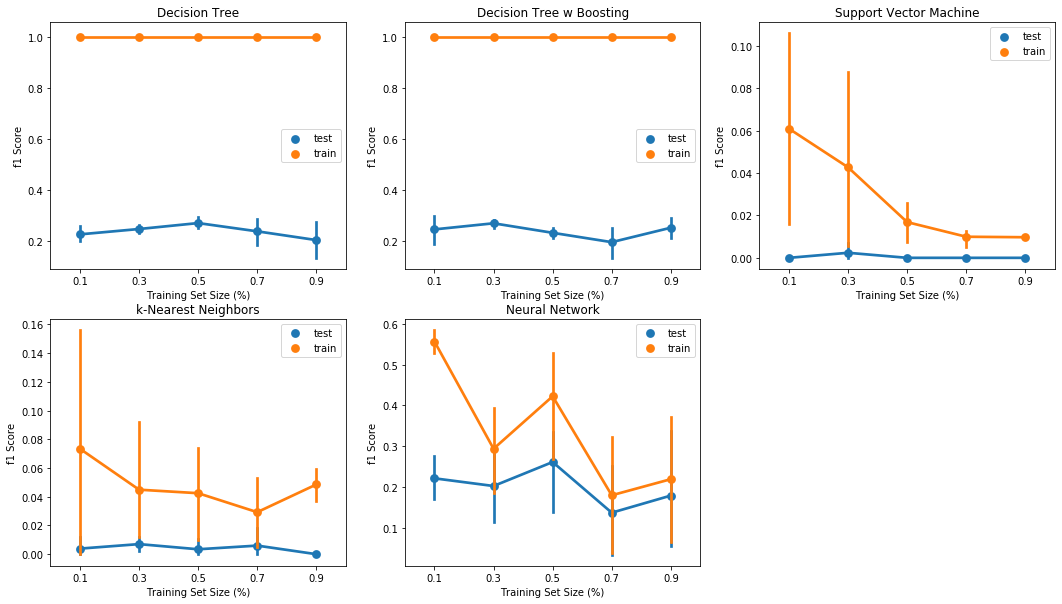

In [21]:
#X_all = df_motogpallfeatures.values
X_all = df_motogpkbestfeatures.values
#X_all = df_motogpnoidfeatures.values

y_true_all = df_motogplabel['rresultPlace'].values

fig = generate_learningcurves(y_true_all, X_all, 'f1')

In [22]:
fig.savefig('images/motogplc.png', bbox_inches='tight', pad_inches=0.2)

Generate complexity plots

In [23]:
def generate_complexitycurves(y_true_all, X_all, metric):
    """  """

    np.random.seed(0)

    X_train, y_true_train, X_test, y_true_test = shuffle_split_data(y_true_all, X_all, 0.3)

    plt.clf()

    fig = plt.figure(figsize=(18, 10))

    # DT -------------------------------

    from sklearn.tree import DecisionTreeClassifier

    df_temp = pd.DataFrame(columns=['s', 'score', 'set'])

    max_depth = np.linspace(1, 20, 10, dtype=int)

    for p in max_depth:
        for i in range(0, 5):
            clf = DecisionTreeClassifier(max_depth=p)
            clf = clf.fit(X_train[:, 1:], y_true_train)

            train_s = eval_clf(clf, X_train, y_true_train, metric)
            test_s = eval_clf(clf, X_test, y_true_test, metric)

            df_temp.loc[len(df_temp.index)] = [p, test_s, 'test']
            df_temp.loc[len(df_temp.index)] = [p, train_s, 'train']

    ax = fig.add_subplot(2, 3, 1)

    ax = sns.pointplot(x='s', y='score', hue='set', data=df_temp)

    ax.legend()
    ax.set_title('Decision Tree')
    ax.set_xlabel('max_depth')
    ax.set_ylabel(metric + ' Score')
    # ax.set_xlim([1, 15])

    # DT w Boost -------------------------------

    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.tree import DecisionTreeClassifier

    df_temp = pd.DataFrame(columns=['s', 'score', 'set'])

    n_estimators = np.linspace(10, 100, 10, dtype=int)

    for p in n_estimators:
        for i in range(0, 5):
            clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=p)
            clf = clf.fit(X_train[:, 1:], y_true_train)

            train_s = eval_clf(clf, X_train, y_true_train, metric)
            test_s = eval_clf(clf, X_test, y_true_test, metric)

            df_temp.loc[len(df_temp.index)] = [p, test_s, 'test']
            df_temp.loc[len(df_temp.index)] = [p, train_s, 'train']

    ax = fig.add_subplot(2, 3, 2)

    ax = sns.pointplot(x='s', y='score', hue='set', data=df_temp)

    ax.legend()
    ax.set_title('Decision Tree w Boosting')
    ax.set_xlabel('n_estimators')
    ax.set_ylabel(metric + ' Score')
    # ax.set_xlim([10, 100])

    # SVC -------------------------------

    from sklearn.svm import SVC, LinearSVC

    df_temp = pd.DataFrame(columns=['s', 'score', 'set'])

    # gamma = np.linspace(0.0001, 1, 10)
    gamma = np.round(np.linspace(0.0001, 0.01, 10), 10)
    # maxit = np.linspace(1000, 10000, 10, dtype=int)

    for p in gamma:
        # for m in maxit:
        for i in range(0, 5):
            # clf = SVC(probability=True, gamma=p)
            clf = SVC(probability=True, gamma=p)
            clf = clf.fit(X_train[:, 1:], y_true_train)

            train_s = eval_clf(clf, X_train, y_true_train, metric)
            test_s = eval_clf(clf, X_test, y_true_test, metric)

            df_temp.loc[len(df_temp.index)] = [p, test_s, 'test']
            df_temp.loc[len(df_temp.index)] = [p, train_s, 'train']

    ax = fig.add_subplot(2, 3, 3)

    ax = sns.pointplot(x='s', y='score', hue='set', data=df_temp)

    ax.legend()
    ax.set_title('Support Vector Machine')
    ax.set_xlabel('gamma')
    ax.set_ylabel(metric + ' Score')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    # ax.set_xlim([0.0001, 0.001])

    # kNN -------------------------------

    from sklearn.neighbors import KNeighborsClassifier

    df_temp = pd.DataFrame(columns=['s', 'score', 'set'])

    neighbors = np.linspace(1, 5, 5, dtype=int)

    for p in neighbors:
        for i in range(0, 5):
            clf = KNeighborsClassifier(n_neighbors=p)
            clf = clf.fit(X_train[:, 1:], y_true_train)

            train_s = eval_clf(clf, X_train, y_true_train, metric)
            test_s = eval_clf(clf, X_test, y_true_test, metric)

            df_temp.loc[len(df_temp.index)] = [p, test_s, 'test']
            df_temp.loc[len(df_temp.index)] = [p, train_s, 'train']

    ax = fig.add_subplot(2, 3, 4)

    ax = sns.pointplot(x='s', y='score', hue='set', data=df_temp)

    ax.legend()
    ax.set_title('k-Nearest Neighbors')
    ax.set_xlabel('neighbors')
    ax.set_ylabel(metric + ' Score')
    ax.invert_xaxis()
    # ax.set_xlim([1, 5])

    # MLP -------------------------------

    from sklearn.neural_network import MLPClassifier

    df_temp = pd.DataFrame(columns=['s', 'score', 'set'])

    alpha = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

    for p in alpha:
        for i in range(0, 5):
            clf = MLPClassifier(alpha=p)
            clf = clf.fit(X_train[:, 1:], y_true_train)

            train_s = eval_clf(clf, X_train, y_true_train, metric)
            test_s = eval_clf(clf, X_test, y_true_test, metric)

            df_temp.loc[len(df_temp.index)] = [p, test_s, 'test']
            df_temp.loc[len(df_temp.index)] = [p, train_s, 'train']

    ax = fig.add_subplot(2, 3, 5)

    ax = sns.pointplot(x='s', y='score', hue='set', data=df_temp)

    ax.legend()
    ax.set_title('Neural Network')
    ax.set_xlabel('alpha')
    ax.set_ylabel(metric + ' Score')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.invert_xaxis()
    # ax.set_xlim([1, 5])

    return fig

C:\Users\buswedg\Anaconda3\envs\Python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\buswedg\Anaconda3\envs\Python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\buswedg\Anaconda3\envs\Python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\buswedg\Anaconda3\envs\Python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached an

<Figure size 432x288 with 0 Axes>

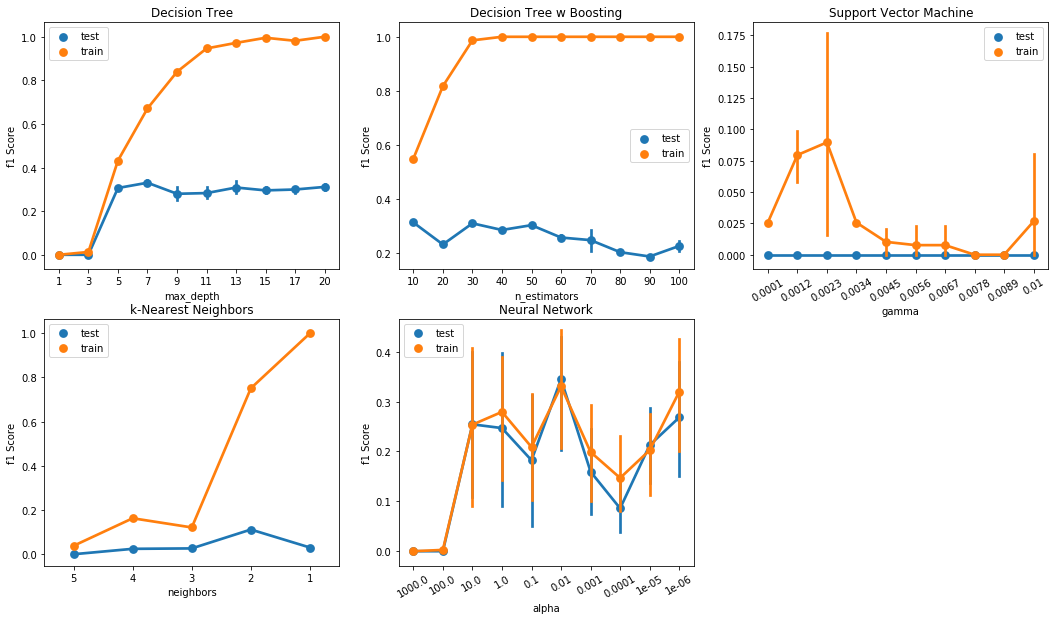

In [24]:
#X_all = df_motogpallfeatures.values
X_all = df_motogpkbestfeatures.values
#X_all = df_motogpnoidfeatures.values

y_true_all = df_motogplabel['rresultPlace'].values

fig = generate_complexitycurves(y_true_all, X_all, 'f1')

In [25]:
fig.savefig('images/motogpcc.png', bbox_inches='tight', pad_inches=0.2)

Perform gridsearch cross validation optimization

In [26]:
def build_clf_list(clf_select):
    list_ref = []
    list_clf = []
    list_param = []

    if 1 in clf_select:
        ref = 'mmscale'
        clf = 'MinMaxScaler()'
        dict_param = {}
        list_ref.append((ref))
        list_clf.append((clf))
        list_param.append((dict_param))

    if 2 in clf_select:
        ref = 'stdscale'
        clf = 'StandardScaler()'
        dict_param = {}
        list_ref.append((ref))
        list_clf.append((clf))
        list_param.append((dict_param))

    if 3 in clf_select:
        ref = 'skb'
        clf = 'SelectKBest()'
        dict_param = {'k': [2, 4, 6, 8, 10, 12, 14, 16, 'all']}
        list_ref.append((ref))
        list_clf.append((clf))
        list_param.append((dict_param))

    if 4 in clf_select:
        ref = 'naive'
        clf = 'GaussianNB()'
        dict_param = {}
        list_ref.append((ref))
        list_clf.append((clf))
        list_param.append((dict_param))

    if 5 in clf_select:
        # http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
        ref = 'dt'
        clf = 'DecisionTreeClassifier()'
        dict_param = {'criterion': ['gini', 'entropy'],  # default='gini'
                      'splitter': ['random', 'best'],  # default='best'
                      'max_depth': [1, 2, 3, 4, 5, 6, 7],  # default=None
                      'max_features': ['auto', None]}  # default=None
        list_ref.append((ref))
        list_clf.append((clf))
        list_param.append((dict_param))

    if 6 in clf_select:
        # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
        ref = 'dtb'
        clf = 'AdaBoostClassifier(DecisionTreeClassifier())'
        dict_param = {'base_estimator__max_depth': [1, 2, 3, 4, 5, 6, 7],  # default=None
                      'n_estimators': [10, 15, 20, 25, 30, 35, 40],  # default=50
                      'learning_rate': [0.001, 0.01, 0.1, 1.0]}  # default=1.
        list_ref.append((ref))
        list_clf.append((clf))
        list_param.append((dict_param))

    if 7 in clf_select:
        # http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
        ref = 'linsvc'
        clf = 'SVC()'
        # 'kernel': ['rbf', 'linear', 'poly'], # default='rbf'
        dict_param = {'kernel': ['rbf'],  # default='rbf'
                      'C': [0.001, 0.01, 0.1, 1.0],  # default=1.0
                      'gamma': [0.0001, 0.001, 0.01, 0.1, 'auto'],  # default='auto'
                      'tol': [0.00001, 0.0001, 0.001],  # default=1e-3
                      'probability': [True]}  # default=False
        list_ref.append((ref))
        list_clf.append((clf))
        list_param.append((dict_param))

    if 8 in clf_select:
        # http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
        ref = 'knn'
        clf = 'KNeighborsClassifier()'
        dict_param = {'n_neighbors': [2, 3, 4, 5, 6],  # default = 5
                      'leaf_size': [10, 20, 30, 40, 50],  # default = 30
                      'n_jobs': [-1]}  # default = 1
        list_ref.append((ref))
        list_clf.append((clf))
        list_param.append((dict_param))

    if 9 in clf_select:
        # http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
        ref = 'mlp'
        clf = 'MLPClassifier()'
        dict_param = {'solver': ['lbfgs', 'sgd', 'adam'],  # default 'adam'
                      'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],  # default 0.0001
                      'tol': [0.000001, 0.00001, 0.0001, 0.001]}  # default=1e-4
        list_ref.append((ref))
        list_clf.append((clf))
        list_param.append((dict_param))

    return list_ref, list_clf, list_param

In [27]:
def eval_clf_list(list_clf, X, y_true, metric):
    list_clfscore = []

    for clf in list_clf:
        score = eval_clf(clf, X, y_true, 'f1')
        list_clfscore.append((score))

    return list_clfscore

In [28]:
def build_pipe(ref, clf, dict_param):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import StandardScaler
    from sklearn.feature_selection import SelectKBest
    from sklearn.naive_bayes import GaussianNB
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.svm import SVC, LinearSVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.neural_network import MLPClassifier

    list_piperef = []
    dict_pipeparam = {}

    list_piperef.append((ref, eval(clf)))

    for key, value in dict_param.items():
        dict_pipeparam[ref + "__" + key] = value

    return list_piperef, dict_pipeparam

In [29]:
def build_pipe_list(list_ref, list_clf, list_param):
    import itertools

    list_piperefs = []
    dict_pipeparams = {}

    for ref, clf, dict_param in zip(list_ref, list_clf, list_param):
        list_piperef, dict_pipeparam = build_pipe(ref, clf, dict_param)

        list_piperefs.append((list_piperef[0][0], list_piperef[0][1]))
        dict_pipeparams.update(dict_pipeparam)

    return list_piperefs, dict_pipeparams

In [30]:
def execute_pipe(clf_select, X_all, X_test, y_true_all, y_true_test):
    "" ""

    import timeit

    from sklearn.pipeline import Pipeline
    #from sklearn.model_selection import StratifiedShuffleSplit
    from sklearn.model_selection import GridSearchCV

    start = timeit.default_timer()

    list_ref, list_clf, list_param = build_clf_list(clf_select)
    list_piperefs, dict_pipeparams = build_pipe_list(list_ref, list_clf, list_param)

    pipe = Pipeline(list_piperefs)
    #cv = StratifiedShuffleSplit(y_true_all, test_size=0.3)
    
    np.random.seed(0)

    grid_search = GridSearchCV(pipe, dict_pipeparams, n_jobs=1, scoring='f1')
    
    grid_search.fit(X_all[:, 1:], y_true_all)

    stop = timeit.default_timer()

    time = (stop - start) / 60

    clf_best = grid_search.best_estimator_
    # print(clf_best)

    param_best = grid_search.best_params_
    # print(param_best)

    score_best = grid_search.best_score_
    # print(score_best)

    f1score = eval_clf(clf_best, X_test, y_true_test, 'f1')
    recall = eval_clf(clf_best, X_test, y_true_test, 'recall')
    precision = eval_clf(clf_best, X_test, y_true_test, 'precision')
    # print("Recall:", recall, "Precision:", precision, "F1 Score:", f1score)

    # list_results = [list_clf[0], param_best, f1score, recall, precision, time]
    list_results = [list_clf, param_best, f1score, recall, precision, time]

    return list_results

In [31]:
#X_all = df_motogpallfeatures.values
X_all = df_motogpkbestfeatures.values
#X_all = df_motogpnoidfeatures.values

y_true_all = df_motogplabel['rresultPlace'].values

X_train, y_true_train, X_test, y_true_test = shuffle_split_data(y_true_all, X_all, 0.25)

clf_select = [[5], [6], [7], [8], [9]]

df_motogpresults = pd.DataFrame(columns=['clf', 'param', 'f1', 'recall', 'precision', 'time'])

for c in clf_select:
    list_results = execute_pipe(c, X_all, X_test, y_true_all, y_true_test)
    df_motogpresults.loc[len(df_motogpresults.index)] = list_results

In [32]:
df_motogpresults

,clf,param,f1,recall,precision,time
0,[DecisionTreeClassifier()],"{'dt__criterion': 'gini', 'dt__max_depth': 6, ...",0.225806,0.132075,0.777778,0.046610
1,[AdaBoostClassifier(DecisionTreeClassifier())],"{'dtb__base_estimator__max_depth': 1, 'dtb__le...",0.423529,0.339623,0.562500,8.677857
2,[SVC()],"{'linsvc__C': 0.001, 'linsvc__gamma': 0.0001, ...",0.037037,0.018868,1.000000,23.621196
3,[KNeighborsClassifier()],"{'knn__leaf_size': 10, 'knn__n_jobs': -1, 'knn...",0.107143,0.056604,1.000000,0.198638
4,[MLPClassifier()],"{'mlp__alpha': 1e-05, 'mlp__solver': 'adam', '...",0.125000,0.075472,0.363636,3.741494


Finish off with some benchmarking

In [33]:
def benchmark(dict_motodata):
    ""

    tp = 0
    fp = 0
    fn = 0

    df_motorresult = dict_motodata['rresult']

    list_motorresultsessid = df_motorresult["sessionId"].unique()

    for i in range(1, len(list_motorresultsessid), 1):
        currsessionId = list_motorresultsessid[i]
        prevsessionId = list_motorresultsessid[i-1]

        pred = df_motorresult[(df_motorresult['sessionId'] == prevsessionId) & \
                              (df_motorresult['rresultPlace'] == 1)]['riderId'].iloc[0]
        
        win = df_motorresult[(df_motorresult['sessionId'] == currsessionId) & \
                             (df_motorresult['rresultPlace'] == 1)]['riderId'].iloc[0]
        
        if win == pred:
            tp += 1
        else:
            fp += 1
            fn += 1
            
    recall = float(tp) / (tp+fn)
    precision = float(tp) / (tp+fp)
    f1score = 2 * (precision * recall) / (precision + recall)
    
    return recall, precision, f1score

In [34]:
recall, precision, f1score = benchmark(dict_motogpdata)

print("F1 Score:", f1score)

F1 Score: 0.3146551724137931
